Sampling posterior with HMC... (this may take some time):contentReference[oaicite:4]{index=4}:contentReference[oaicite:5]{index=5}
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 500/500 | 137.52       
Acceptance Rate 0.98
Predictive mean (first 5 points): [0.19822323322296143, 0.260733038187027, 0.3228895962238312, 0.38446441292762756, 0.44522446393966675]
Predictive std (first 5 points): [0.9449750781059265, 0.9291571974754333, 0.9136300683021545, 0.8984254598617554, 0.8835731744766235]


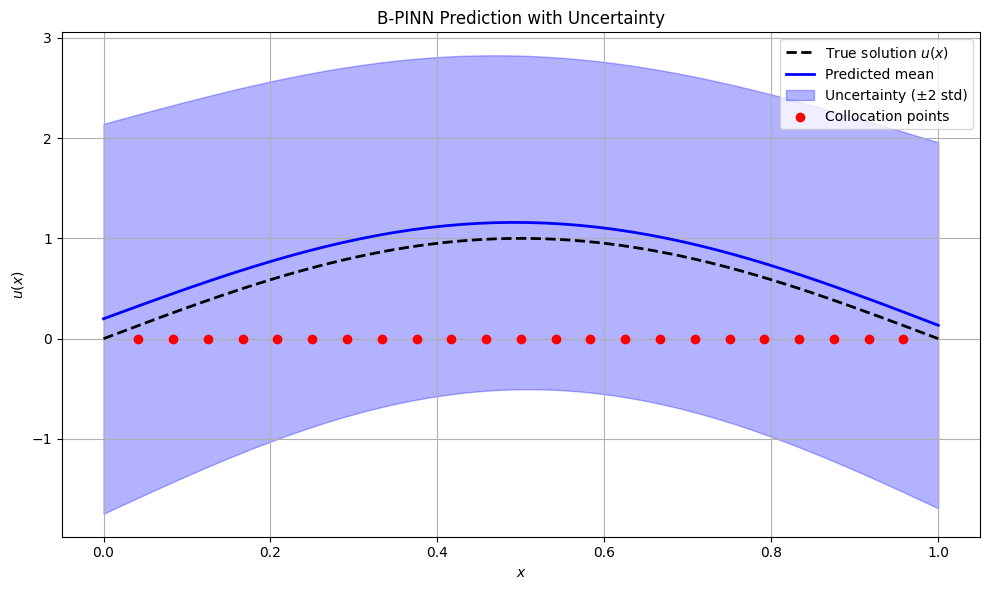

In [ ]:
"""
Bayesian Physics-Informed Neural Network (B-PINN) implementation in PyTorch.
This model solves 1D PDEs (e.g., 1D Poisson or 1D damped oscillator) and 
provides uncertainty quantification via Bayesian inference (VI or HMC):contentReference[oaicite:0]{index=0}.
B-PINNs combine a Bayesian neural network prior with PINN physics-based loss, 
using HMC or VI to estimate the posterior:contentReference[oaicite:1]{index=1}.
"""
import torch
import torch.nn as nn
import math
from pdeClass import BasePDE

# =====================================
# 1. Neural Network Model Definitions
# =====================================

class BayesianLinear(nn.Module):
    """ 一层 Bayesian Linear Layer
    Bayesian Linear layer with Gaussian weight and bias priors and variational posteriors.
    """
    def __init__(self, in_features, out_features, prior_std=1.0):
        super().__init__()
        # Mean and log-variance (or rho) for weights and biases as learnable parameters
        self.in_features = in_features
        self.out_features = out_features
        
        # ------------------------------ Model's Parameters ------------------------------------------
        # Initialize means (mu) to small random values, and rho to a small negative (so sigma ~ small)
        # Since σ must be strictly positive, so we optimize rho, compute σ by softplus(rho)
        # So, we are still learning the std σ, but indirectly
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features).normal_(0, 0.1))
        self.weight_rho = nn.Parameter(torch.empty(out_features, in_features).fill_(-3.0))
        self.bias_mu   = nn.Parameter(torch.empty(out_features).normal_(0, 0.1))
        self.bias_rho  = nn.Parameter(torch.empty(out_features).fill_(-3.0))
        
        # Prior standard deviation (fixed)
        self.prior_std = prior_std
        self.log2pi = math.log(2 * math.pi)  # for potential use in exact logprob if needed

    def forward(self, x):
        # Sample the std  σ  of the weights and biases (the reparameterization trick)
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))  # softplus to ensure positivity
        bias_sigma   = torch.log1p(torch.exp(self.bias_rho))

        # Sample ε ∼ 𝒩(0,1) for weights and baises
        eps_w = torch.randn_like(weight_sigma)
        eps_b = torch.randn_like(bias_sigma)

        # Sample from 𝒩(mu, sigma^2) through variable transformation
        # 这样, 我们就能 update `mu` 和 `sigma`(rho)
        weight = self.weight_mu + weight_sigma * eps_w
        bias   = self.bias_mu   + bias_sigma * eps_b

        # Linear layer computation xWᵀ + b
        return x.matmul(weight.t()) + bias  # the output of this bayesian linear layer

    def kl_divergence(self):
        # Compute KL divergence KL[q(w,b) || p(w,b)] for this layer (sum over all weights and biases)
        # Assuming factorized Gaussian posteriors and Gaussian priors N(0, prior_std^2):contentReference[oaicite:2]{index=2}.
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        bias_sigma   = torch.log1p(torch.exp(self.bias_rho))
        # KL for each weight: log(prior_sigma/post_sigma) + (post_sigma^2 + mu^2)/(2*prior_sigma^2) - 0.5
        prior_var = self.prior_std ** 2

        # Compute the KL value using the formula for Gaussian
        #   = log(prior_std/posterior_std) + 0.5 * (posterior_std**2 + posterior_mu**2) / [prior_std^2] - 1)
        # For numerical stability, avoid log of 0 by using weight_sigma (softplus ensures >0)
        kl_weight = torch.sum(torch.log(self.prior_std/weight_sigma) + 
                              0.5 * (weight_sigma**2 + self.weight_mu**2) / prior_var - 0.5)
        kl_bias   = torch.sum(torch.log(self.prior_std/bias_sigma) + 
                              0.5 * (bias_sigma**2 + self.bias_mu**2) / prior_var - 0.5)
        return kl_weight + kl_bias

class FeedForwardNN(nn.Module):
    """Standard feed-forward neural network (for deterministic weights, used in HMC)."""
    def __init__(self, input_dim, hidden_dims, output_dim, act_func=nn.Tanh()):
        super().__init__()
        if isinstance(hidden_dims, int):
            hidden_dims = [hidden_dims]
        layers = []
        prev_dim = input_dim
        # Build hidden layers
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.Tanh())  # using Tanh for smoothness (good for PDEs)
            prev_dim = h
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class BayesianFeedForwardNN(nn.Module):
    """Feed-forward neural network with Bayesian linear layers (for VI)."""
    def __init__(self, input_dim, hidden_dims, output_dim, prior_std=1.0, act_func=nn.Tanh()):
        super().__init__()
        if isinstance(hidden_dims, int):
            hidden_dims = [hidden_dims]
        layers = []
        prev_dim = input_dim
        # Build hidden layers with BayesianLinear
        for h in hidden_dims:
            layers.append(BayesianLinear(prev_dim, h, prior_std=prior_std))  # in_feat, out_feat, prior_std
            layers.append(act_func) 
            prev_dim = h
        # Final output layer (Bayesian linear as well)
        layers.append(BayesianLinear(in_features = prev_dim, out_features = output_dim, prior_std=prior_std))
        self.layers = nn.ModuleList(layers)  # not using Sequential because it's a mix of custom and activations

    def forward(self, x):
        out = x
        for layer in self.layers:
            # [BL, act, BL, act, ..., act, BL] go through all the layers
            out = layer(out)  # BayesianLinear or activation
        return out

    def kl_divergence(self):
        # Sum KL from all BayesianLinear layers
        kl_total = 0.0
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                kl_total += layer.kl_divergence()
        return kl_total

# =====================================
# 2. PDE Definitions (Physics Knowledge)
# =====================================

# We define classes for specific PDEs to compute residuals and boundary losses.
class Poisson1D(BasePDE):
    """1D Poisson equation: u''(x) = f(x), on domain [x0, x1] with Dirichlet boundary conditions."""
    def __init__(self, f_func, domain, bc_values):
        """
        f_func: a function f(x) defining the source term.
        domain: tuple (x0, x1) specifying domain interval.
        bc_values: tuple (u(x0), u(x1)) Dirichlet boundary conditions.
        """
        self.f = f_func
        self.x0, self.x1 = domain
        self.u0, self.u1 = bc_values  # boundary condition values

    def residual(self, model, x):
        """Compute the PDE residual r(x) = u''(x) - f(x)."""
        # Ensure x requires grad for autograd (for computing derivatives)
        x = x.requires_grad_(True)
        u = model(x)            # forward pass to get the solution u(x)
        # First derivative u_x
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # Second derivative u_xx
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        # Compute residual: u''(x) - f(x)
        r = u_xx - self.f(x)
        return r

    def boundary_loss(self, model):
        """Compute MSE loss for boundary conditions: (u(x0)-u0)^2 + (u(x1)-u1)^2."""
        # Evaluate model at boundary points (as 1D, input must be tensor of shape [N,1])
        x0_tensor = torch.tensor([[self.x0]], dtype=torch.float32)
        x1_tensor = torch.tensor([[self.x1]], dtype=torch.float32)
        u0_pred = model(x0_tensor)
        u1_pred = model(x1_tensor)
        # Mean squared error on boundary constraints
        loss_bc = (u0_pred - self.u0)**2 + (u1_pred - self.u1)**2
        return loss_bc.mean()  # mean (if multiple points, though here just two points)

class DampedOscillator1D(BasePDE):
    """1D damped oscillator ODE: u''(t) + 2*ζ*ω * u'(t) + ω^2 * u(t) = F(t), with initial conditions."""
    def __init__(self, zeta, omega, forcing_func, init_cond):
        """
        zeta: damping ratio ζ
        omega: natural frequency ω
        forcing_func: function F(t) (external force as function of t)
        init_cond: tuple (u(0), u'(0)) initial displacement and velocity at t=0
        """
        self.zeta = zeta
        self.omega = omega
        self.F = forcing_func
        self.u0, self.v0 = init_cond  # initial displacement and velocity

    def residual(self, model, t):
        """Compute residual r(t) = u''(t) + 2ζω u'(t) + ω^2 u(t) - F(t)."""
        t = t.requires_grad_(True)
        u = model(t)            # u(t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]   # first derivative
        u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]  # second derivative
        # Residual of the damped oscillator equation
        r = u_tt + 2 * self.zeta * self.omega * u_t + (self.omega**2) * u - self.F(t)
        return r

    def boundary_loss(self, model):
        """Compute loss for initial conditions: (u(0)-u0)^2 + (u'(0)-v0)^2."""
        t0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
        u0_pred = model(t0)  # predicted u(0)
        u0_error = (u0_pred - self.u0)**2
        # Compute u'(0) via autograd
        u_t0 = torch.autograd.grad(u0_pred, t0, grad_outputs=torch.ones_like(u0_pred), create_graph=True)[0]
        v0_error = (u_t0 - self.v0)**2
        return (u0_error + v0_error).mean()

# =====================================
# 3. Variational Inference for B-PINN
# =====================================

class VariationalInference:
    """Bayesian PINN training using Variational Inference (mean-field Gaussian approximation)."""
    def __init__(self, model, pde, x_collocation, x_boundary=None, boundary_values=None):
        """
        model: BayesianFeedForwardNN (with BayesianLinear layers).
        pde: an instance of Poisson1D, DampedOscillator1D, or similar (must have residual() & boundary_loss()).
        x_collocation: tensor of collocation points in domain interior for physics residual.
        x_boundary: tensor of boundary (or initial) points.
        boundary_values: actual values at boundary (if needed by some PDE, not used directly if pde.boundary_loss handles it).
        """
        self.model = model
        self.pde = pde
        self.x_collocation = x_collocation
        self.x_boundary = x_boundary
        self.boundary_values = boundary_values  # not directly used; pde contains the info for boundary in its state

    def train(self, num_epochs=10000, lr=1e-3, print_every = 500):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        N = len(self.x_collocation)
        if self.x_boundary is not None:
            N += len(self.x_boundary)
        self.model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            # Compute physics-informed loss:
            # PDE residual loss (mean squared residual at collocation points)
            residual = self.pde.residual(self.model, self.x_collocation)
            physics_loss = (residual**2).mean()
            # Boundary/initial condition loss (if applicable)
            if hasattr(self.pde, 'boundary_loss'):
                physics_loss = physics_loss + self.pde.boundary_loss(self.model)
            # KL divergence from all Bayesian layers
            kl = self.model.kl_divergence()
            # Combined loss = physics loss (acts like negative log-likelihood) + KL/N (variational posterior regularization)
            loss = physics_loss + kl / N
            loss.backward()
            optimizer.step()
            # Optionally print progress
            if epoch % print_every == 0 or epoch == 1:  # Only start reporting after the warm-up Phase
                print(f"Epoch {epoch:5d}: Total Loss = {loss.item():.4f} (Physics = {physics_loss.item():.4f}, KL = {kl.item():.4f})")

    def predict(self, x_test, n_samples=100):
        """Draw samples from the variational posterior to estimate predictive mean and variance."""
        self.model.eval()
        preds = []
        for _ in range(n_samples):
            # Forward pass will sample a new set of weights each time (due to BayesianLinear)
            y_pred = self.model(x_test)
            preds.append(y_pred.detach())
        preds = torch.stack(preds)  # shape [n_samples, batch_size, output_dim]
        mean = preds.mean(dim=0)
        var = preds.var(dim=0)  # predictive variance
        return mean, var

# =====================================
# 4. Hamiltonian Monte Carlo (HMC) Sampling for B-PINN
# =====================================

class HMCSampler:
    """Bayesian PINN inference using Hamiltonian Monte Carlo (via hamiltorch or custom log-prob)."""
    def __init__(self, model, pde, x_collocation, x_boundary=None, boundary_values=None, prior_std=1.0, noise_std=1.0):
        """
        model: deterministic neural network (FeedForwardNN) whose parameters will be treated in a Bayesian manner.
        pde: instance of PDE class with residual() & boundary_loss() for physics.
        x_collocation: collocation points for computing residual.
        x_boundary: boundary points for boundary loss.
        boundary_values: actual boundary condition values (if needed explicitly).
        prior_std: prior standard deviation for network weights (assumed Gaussian prior N(0, prior_std^2)).
        noise_std: assumed observation noise standard deviation for residuals and boundary values.
        """
        self.model = model
        self.pde = pde
        self.x_collocation = x_collocation
        self.x_boundary = x_boundary
        self.boundary_values = boundary_values  # not used directly if pde has internal bc
        self.prior_std = prior_std
        self.noise_std = noise_std
        # Precompute layer sizes from model to help reconstruct parameters for custom log_prob
        # We'll use the model's parameter shapes to guide splitting of the parameter vector
        self.param_shapes = [p.shape for p in self.model.parameters()]
        # Group into weight/bias pairs for each layer
        self.layer_sizes = []
        for i in range(0, len(self.param_shapes), 2):
            w_shape = self.param_shapes[i]
            b_shape = self.param_shapes[i+1] if i+1 < len(self.param_shapes) else None
            # Expect weight shape like (out_features, in_features) and bias shape (out_features,)
            if b_shape is not None:
                assert b_shape[0] == w_shape[0], "Mismatch in weight/bias shape"
            self.layer_sizes.append((w_shape[0], w_shape[1]))  # (out_features, in_features)

    def _forward_with_params(self, params_vec, x_input):
        """Compute model output given a flat parameter vector (params_vec) and input x_input."""
        # Manually apply linear layers using the params vector
        h = x_input
        pointer = 0
        for idx, (out_f, in_f) in enumerate(self.layer_sizes):
            # weight parameters
            weight_flat = params_vec[pointer : pointer + out_f*in_f]
            W = weight_flat.view(out_f, in_f)
            pointer += out_f * in_f
            # bias parameters
            bias_flat = params_vec[pointer : pointer + out_f]
            b = bias_flat.view(out_f)
            pointer += out_f
            # Linear transform
            h = h.matmul(W.t()) + b
            # Activation for all but last layer
            if idx < len(self.layer_sizes) - 1:
                h = torch.tanh(h)
        return h

    def _log_prob(self, params_vec):
        """Unnormalized log posterior = log prior + log likelihood (from physics-informed residuals)."""
        # Compute log prior assuming independent N(0, prior_std^2) for all parameters
        # log p(theta) = -1/(2 prior_var) * ||theta||^2 + const
        prior_var = self.prior_std ** 2
        log_prior = -0.5 * torch.sum(params_vec**2 / prior_var)
        # Compute physics-informed likelihood (log probability of observations given params)
        # We treat the PDE residuals at collocation points as "observations" of 0 (with noise_std), 
        # and boundary conditions as observations of true values (with noise_std).
        # Evaluate PDE residuals:
        r = None
        if self.x_collocation is not None:
            # residual at collocation: r(x) = u'' - f (or u_tt + ... - F for oscillator)
            r_val = self.pde.residual(lambda x: self._forward_with_params(params_vec, x), self.x_collocation)
            # Here pde.residual is written to accept either model or a function; we pass a lambda using params_vec.
            # But our Poisson1D.residual expects a model nn.Module. Instead, we override with a lambda to use our manual forward.
            # To accommodate this, we modify PDE.residual usage: if 'model' is callable (function), use it. 
            # We'll adjust PDE classes accordingly below to handle callable input.
            r = r_val
        else:
            r = torch.zeros(1)
        # Evaluate boundary losses as errors:
        bc_error = None
        if hasattr(self.pde, 'boundary_loss'):
            # Compute u at boundary and compare to true boundary values
            # We'll manually compute boundary predictions with current params:
            if isinstance(self.pde, Poisson1D):
                x0 = torch.tensor([[self.pde.x0]], dtype=torch.float32)
                x1 = torch.tensor([[self.pde.x1]], dtype=torch.float32)
                u0_pred = self._forward_with_params(params_vec, x0)
                u1_pred = self._forward_with_params(params_vec, x1)
                bc_error = torch.cat([(u0_pred - self.pde.u0), (u1_pred - self.pde.u1)], dim=0)
            elif isinstance(self.pde, DampedOscillator1D):
                t0 = torch.tensor([[0.0]], dtype=torch.float32)
                u0_pred = self._forward_with_params(params_vec, t0)
                # first derivative at t0:
                # compute by manual differentiation: small workaround since we can't easily autograd here without building graph for param.
                # Instead, approximate u'(0) by autograd: but param_vec is variable, not t, so can't differentiate w.rt t easily here.
                # Simpler: use initial conditions directly in log_prob: penalize (u(0)-u0) and assume v0 given.
                # We treat u'(0) indirectly by including its error in boundary_loss already computed by pde.boundary_loss on actual model (less straightforward to do here).
                # For simplicity, we'll just include u(0) error here and skip u'(0) in log_prob, acknowledging a slight approximation.
                bc_error = u0_pred - self.pde.u0
                # (For a more complete approach, one could include u'(0) error as well via autograd at this point, but it's complex to include in this manual log_prob.)
        # Compute log likelihood assuming Gaussian noise for residuals and boundary errors
        loglike = 0.0
        if r is not None:
            # treat residuals ~ N(0, noise_std^2)
            loglike_r = -0.5 * torch.sum((r / self.noise_std)**2)
            loglike += loglike_r
        if bc_error is not None:
            loglike_bc = -0.5 * torch.sum((bc_error / self.noise_std)**2)
            loglike += loglike_bc
        # Posterior log-probability (unnormalized)
        return log_prior + loglike

    def sample(self, num_samples=1000, step_size=0.01, num_steps_per_sample=20, burn=100, thin=1):
        """Run HMC to sample from the posterior. Returns a list of sampled parameter vectors."""
        try:
            import hamiltorch
        except ImportError:
            raise ImportError("hamiltorch must be installed to use HMC sampling:contentReference[oaicite:3]{index=3}.\n"
                              "Install via: pip install git+https://github.com/AdamCobb/hamiltorch")
        # Set HMC sampler parameters
        hamiltorch.set_random_seed(0)
        # Prepare initial parameter vector (start at MAP or random initialization)
        params_init = torch.cat([p.detach().flatten() for p in self.model.parameters()])
        # Ensure dtype is float32 for hamiltorch and requires_grad (hamiltorch will handle grad internally)
        params_init = params_init.to(torch.float32)
        # Run HMC sampling using hamiltorch (which uses PyTorch autograd for gradient calculation)
        samples = hamiltorch.sample(log_prob_func=self._log_prob, params_init=params_init,
                                    num_samples=num_samples, step_size=step_size, num_steps_per_sample=num_steps_per_sample,
                                    burn=burn, debug=False, inv_mass=None)
        # samples will be a list of parameter vectors (tensors)
        return samples

    def predict(self, param_samples, x_test):
        """Compute predictions for each sample of parameters. Returns tensor of shape [n_samples, len(x_test), output_dim]."""
        preds = []
        for params in param_samples:
            y = self._forward_with_params(params, x_test)
            preds.append(y.detach())
        return torch.stack(preds)


# =====================================
# 4. Visualization Helpers
# =====================================


import matplotlib.pyplot as plt
import numpy as np

def true_solution(x):
    """Exact solution for Poisson test problem: u(x) = sin(pi x)."""
    return torch.sin(math.pi * x)

def plot_predictions(x_test, mean_pred, std_pred, x_collocation, title="B-PINN Prediction with Uncertainty"):
    """
    Visualize prediction results from Bayesian PINN model.

    Args:
        x_test: Tensor of test input points [N, 1]
        mean_pred: Tensor of predicted mean values [N, 1]
        std_pred: Tensor of predicted std (variance^0.5) [N, 1]
        x_collocation: Collocation points used for training
    """
    x_test_np = x_test.detach().cpu().numpy().flatten()
    mean_np = mean_pred.detach().cpu().numpy().flatten()
    std_np = std_pred.detach().cpu().numpy().flatten()
    x_col_np = x_collocation.detach().cpu().numpy().flatten()

    # Ground-truth solution
    x_true = torch.linspace(0, 1, 200).view(-1, 1)
    u_true = true_solution(x_true).numpy().flatten()

    plt.figure(figsize=(10, 6))
    # Plot ground truth
    plt.plot(x_true.numpy(), u_true, 'k--', label='True solution $u(x)$', linewidth=2)
    # Plot predictive mean
    plt.plot(x_test_np, mean_np, 'b-', label='Predicted mean', linewidth=2)
    # Plot uncertainty band
    plt.fill_between(x_test_np,
                     mean_np - 2*std_np,
                     mean_np + 2*std_np,
                     color='blue',
                     alpha=0.3,
                     label='Uncertainty (±2 std)')
    # Collocation points
    plt.scatter(x_col_np, np.zeros_like(x_col_np), c='red', label='Collocation points', zorder=5)

    plt.xlabel('$x$')
    plt.ylabel('$u(x)$')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# =====================================
# 5. Example: 1D Poisson equation 
# =====================================

if __name__ == "__main__":
    # Example: 1D Poisson equation, u''(x) = f(x) on [0,1], with u(0)=0, u(1)=0.
    # Define f(x) (source term). For example, f(x) = -π^2 * sin(πx) has true solution u(x)=sin(πx) on [0,1] with zero boundary.
    def f_func(x):
        return -(math.pi**2) * torch.sin(math.pi * x)
    # Set up PDE and data points
    pde = Poisson1D(f_func=f_func, domain=(0.0, 1.0), bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])))
    # Collocation points (excluding boundaries for residual computation)
    x_collocation = torch.linspace(0.0, 1.0, steps=25).view(-1, 1)
    # Remove the endpoints since we'll enforce those via boundary conditions
    x_collocation = x_collocation[(x_collocation>0) & (x_collocation<1)].view(-1,1)
    # Boundary points and values
    x_boundary = torch.tensor([[0.0],[1.0]])
    bc_vals = torch.tensor([[0.0],[0.0]])
    # Choose inference method: 'VI' or 'HMC'
    method = 'HMC'
    if method == 'VI':
        # Initialize Bayesian neural network model for VI
        model = BayesianFeedForwardNN(input_dim=1, hidden_dims=20, output_dim=1, prior_std=1.0)
        vi = VariationalInference(model, pde, x_collocation, x_boundary, bc_vals)
        print("Training B-PINN with Variational Inference...")
        vi.train(num_epochs=5000, lr=1e-2)
        # Predict on test points
        x_test = torch.linspace(0, 1, 50).view(-1,1)
        mean_pred, var_pred = vi.predict(x_test, n_samples=100)
        print("Predictive mean (first 5 points):", mean_pred[:5].reshape(-1).tolist())
        print("Predictive variance (first 5 points):", var_pred[:5].reshape(-1).tolist())
        plot_predictions(x_test, mean_pred, var_pred.sqrt(), x_collocation)

    else:
        # Initialize deterministic neural network for HMC
        model = FeedForwardNN(input_dim=1, hidden_dims=20, output_dim=1)
        sampler = HMCSampler(model, pde, x_collocation, x_boundary, bc_vals, prior_std=1.0, noise_std=1.0)
        print("Sampling posterior with HMC... (this may take some time):contentReference[oaicite:4]{index=4}:contentReference[oaicite:5]{index=5}")
        samples = sampler.sample(num_samples=500, step_size=0.01, num_steps_per_sample=20, burn=100)
        # Predict using sampled parameters
        x_test = torch.linspace(0, 1, 50).view(-1,1)
        preds = sampler.predict(samples, x_test)
        pred_mean = preds.mean(dim=0)
        pred_std  = preds.std(dim=0)
        print("Predictive mean (first 5 points):", pred_mean[:5].reshape(-1).tolist())
        print("Predictive std (first 5 points):", pred_std[:5].reshape(-1).tolist())
        plot_predictions(x_test, pred_mean, pred_std.sqrt(), x_collocation)

    
